Data Preparation and cleaning

In [83]:
#import necessary libraries
import pandas as pd
import glob
import matplotlib.pyplot as plt

In [84]:
# Find all CSV files in the current directory
csv_files = glob.glob("*.csv")
print(csv_files)


['132kV Line3.csv', '132kV Line5.csv', '33kV IC2.csv']


In [85]:
#Load and combine data from multiple CSV files
file_list = ['132kV Line3.csv', '132kV Line5.csv', '33kV IC2.csv']
dataframes = []

for file in file_list:
    df = pd.read_csv(file)
    
    # Remove unwanted columns and keep only useful ones
    df = df[['Date', 'Time', 'kVA']]  # Adjust if column names differ

    # Add line name
    if '33kV' in file:
        df['Line'] = '33kV'
    elif '132kV Line3' in file:
        df['Line'] = '132kV Line3'
    elif '132kV Line5' in file:
        df['Line'] = '132kV Line5'

    # Combine Date and Time into datetime
    df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)
    df.set_index('Datetime', inplace=True)

    # Optional: drop Date and Time
    df.drop(['Date', 'Time'], axis=1, inplace=True)
    
    dataframes.append(df)

# Combine all dataframes
combined_df = pd.concat(dataframes)

# Preview
print(combined_df.head())


                         kVA         Line
Datetime                                 
2024-02-01 00:00:00  33812.0  132kV Line3
2024-02-01 00:15:00  34861.0  132kV Line3
2024-02-01 00:30:00  32955.0  132kV Line3
2024-02-01 00:45:00  33962.0  132kV Line3
2024-02-01 01:00:00  32714.0  132kV Line3


In [87]:
#Detect Missing 15-Minute Blocks in Power Line Data

# Set frequency to 15 minutes
freq = '15T'

# Store missing timestamps for each line
missing_summary = {}

# Loop over each line separately
for line_name in combined_df['Line'].unique():
    # Filter data for this line
    line_df = combined_df[combined_df['Line'] == line_name].copy()

    # Create full range from min to max datetime
    full_time_range = pd.date_range(start=line_df.index.min(), end=line_df.index.max(), freq=freq)

    # Find missing timestamps
    missing_timestamps = full_time_range.difference(line_df.index)

    # Store the result
    missing_summary[line_name] = {
        'Total expected': len(full_time_range),
        'Actual present': len(line_df),
        'Missing count': len(missing_timestamps),
        'Missing timestamps': missing_timestamps
    }

# Print missing blocks summary
for line, summary in missing_summary.items():
    print(f"\nLine: {line}")
    print(f"Total expected blocks   : {summary['Total expected']}")
    print(f"Actual recorded blocks  : {summary['Actual present']}")
    print(f"Missing blocks (15-min) : {summary['Missing count']}")
    if summary['Missing count'] > 0:
        print("Some missing timestamps:")
        print(summary['Missing timestamps'][:10])  # Print first 10 missing times



Line: 132kV Line3
Total expected blocks   : 39552
Actual recorded blocks  : 38880
Missing blocks (15-min) : 2276
Some missing timestamps:
DatetimeIndex(['2024-02-01 17:00:00', '2024-02-01 17:15:00',
               '2024-02-02 07:30:00', '2024-02-02 08:45:00',
               '2024-02-02 21:30:00', '2024-02-02 21:45:00',
               '2024-02-02 22:00:00', '2024-02-02 22:15:00',
               '2024-02-04 16:45:00', '2024-02-05 00:15:00'],
              dtype='datetime64[ns]', freq=None)

Line: 132kV Line5
Total expected blocks   : 39552
Actual recorded blocks  : 38886
Missing blocks (15-min) : 2285
Some missing timestamps:
DatetimeIndex(['2024-02-01 17:00:00', '2024-02-01 17:15:00',
               '2024-02-02 07:30:00', '2024-02-02 08:45:00',
               '2024-02-02 21:30:00', '2024-02-02 21:45:00',
               '2024-02-02 22:00:00', '2024-02-02 22:15:00',
               '2024-02-04 16:45:00', '2024-02-05 00:15:00'],
              dtype='datetime64[ns]', freq=None)

Line: 33kV


C:\Users\Shruti\AppData\Local\Temp\ipykernel_28904\3445442256.py:15: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_time_range = pd.date_range(start=line_df.index.min(), end=line_df.index.max(), freq=freq)


In [5]:

# Set 15-minute frequency
freq = '15T'

# Create dictionary to store missing timestamp summaries
missing_summary = {}

# Create a DataFrame to store the fully resampled time series
full_time_series = pd.DataFrame()

# Loop through each unique line
for line_name in combined_df['line'].unique():
    # Filter data for that line
    line_df = combined_df[combined_df['line'] == line_name].copy()

    # Remove duplicate timestamps to avoid reindexing errors
    line_df = line_df[~line_df.index.duplicated(keep='first')]

    # Sort by datetime index
    line_df = line_df.sort_index()

    # Create the full expected time range
    full_time_range = pd.date_range(start=line_df.index.min(), end=line_df.index.max(), freq=freq)

    # Reindex to the full time range (introducing NaNs where timestamps are missing)
    line_df = line_df.reindex(full_time_range)

    # Rename index to 'Datetime' (optional but for consistency)
    line_df.index.name = 'Datetime'

    # Store line info
    line_df['line'] = line_name

    # Save missing timestamp details
    missing_timestamps = line_df[line_df['kva'].isna()].index

    missing_summary[line_name] = {
        'Total expected': len(full_time_range),
        'Actual present': combined_df[combined_df['line'] == line_name].shape[0],
        'Missing count': len(missing_timestamps),
        'Missing timestamps': missing_timestamps
    }

    # Append to full resampled time series
    full_time_series = pd.concat([full_time_series, line_df])

# Sort the combined result by time
full_time_series = full_time_series.sort_index()

# Print summary
for line, summary in missing_summary.items():
    print(f"\nLine: {line}")
    print(f"Total expected blocks : {summary['Total expected']}")
    print(f"Actual recorded blocks : {summary['Actual present']}")
    print(f"Missing blocks (15-min) : {summary['Missing count']}")
    if summary['Missing count'] > 0:
        print("Some missing timestamps:")
        print(summary['Missing timestamps'][:10])

# Final output
print("\nFinal resampled DataFrame with explicit NaNs for missing time blocks:")
print(full_time_series.head(50))
print("\nFinal DataFrame Info:")
full_time_series.info()


KeyError: 'line'

In [88]:
print(combined_df.columns)


Index(['kVA', 'Line'], dtype='object')


In [89]:

# Resample Each Line's Data to 15-minute Intervals
full_time_series = pd.DataFrame()

for line_name in combined_df['Line'].unique():
    line_df = combined_df[combined_df['Line'] == line_name].copy()
    line_df = line_df.sort_index()

    # Resample to 15-minute intervals and take the mean
    resampled = line_df[['kVA']].resample('15T').mean()

    # Add Line back
    resampled['Line'] = line_name

    # Append to full
    full_time_series = pd.concat([full_time_series, resampled])

# Sort by datetime index
full_time_series = full_time_series.sort_index()

print("Resampled Data Sample:")
print(full_time_series.head(5))

#Detect Missing Time Blocks for Each Line 
freq = '15min'
missing_summary = {}

for line_name in full_time_series['Line'].unique():
    line_df = full_time_series[full_time_series['Line'] == line_name]
    line_df = line_df.sort_index()

    # Generate expected range of datetimes
    full_range = pd.date_range(start=line_df.index.min(), end=line_df.index.max(), freq=freq)

    # Identify missing timestamps
    resampled_df = line_df[['kVA']].resample(freq).mean()
    missing_timestamps = full_range.difference(resampled_df.index)

    missing_summary[line_name] = {
        'Total expected': len(full_range),
        'Actual present': len(resampled_df),
        'Missing count': len(missing_timestamps),
        'Missing timestamps': missing_timestamps
    }

#Print Summary 
for line_name, summary in missing_summary.items():
    print(f"\Line: {line_name}")
    print(f"Total expected blocks : {summary['Total expected']}")
    print(f"Actual recorded blocks : {summary['Actual present']}")
    print(f"Missing blocks (15-min) : {summary['Missing count']}")
    if summary['Missing count'] > 0:
        print("Some missing timestamps:")
        print(summary['Missing timestamps'][:10])

Resampled Data Sample:
                         kVA         Line
Datetime                                 
2024-02-01 00:00:00  33812.0  132kV Line3
2024-02-01 00:00:00  27237.0         33kV
2024-02-01 00:00:00  33711.0  132kV Line5
2024-02-01 00:15:00  34861.0  132kV Line3
2024-02-01 00:15:00  25668.0         33kV
\Line: 132kV Line3
Total expected blocks : 39552
Actual recorded blocks : 39552
Missing blocks (15-min) : 0
\Line: 33kV
Total expected blocks : 39552
Actual recorded blocks : 39552
Missing blocks (15-min) : 0
\Line: 132kV Line5
Total expected blocks : 39552
Actual recorded blocks : 39552
Missing blocks (15-min) : 0


C:\Users\Shruti\AppData\Local\Temp\ipykernel_28904\1251083385.py:9: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled = line_df[['kVA']].resample('15T').mean()
C:\Users\Shruti\AppData\Local\Temp\ipykernel_28904\1251083385.py:9: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled = line_df[['kVA']].resample('15T').mean()
C:\Users\Shruti\AppData\Local\Temp\ipykernel_28904\1251083385.py:9: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled = line_df[['kVA']].resample('15T').mean()


In [90]:
# Check how many NaNs before fixing
print("Missing values before:", combined_df['kVA'].isna().sum())

# Forward fill
combined_df['kVA'] = combined_df['kVA'].ffill()

# Backward fill
combined_df['kVA'] = combined_df['kVA'].bfill()

# 3. Fill any remaining NaNs with the overall mean
combined_df['kVA'] = combined_df['kVA'].fillna(combined_df['kVA'].mean())

print("Missing values after:", combined_df['kVA'].isna().sum())


Missing values before: 3
Missing values after: 0


In [91]:
print(combined_df['kVA'].isna().sum())
print(combined_df.info())


0
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 116683 entries, 2024-02-01 00:00:00 to NaT
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   kVA     116683 non-null  float64
 1   Line    116683 non-null  object 
dtypes: float64(1), object(1)
memory usage: 2.7+ MB
None


In [ ]:
#Handle Missing Data by Filling NaNs with Mean and Forward Fill
#combined_df['kVA'] = combined_df['kVA'].fillna(combined_df['kVA'].mean())
#combined_df['kVA'] = combined_df['kVA'].fillna(method='ffill')

C:\Users\Shruti\AppData\Local\Temp\ipykernel_14348\1906558648.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_df['kVA'] = combined_df['kVA'].fillna(method='ffill')


In [92]:
# Check missing values per column
print("\nMissing Values per Column:")
print(combined_df.isnull().sum())


Missing Values per Column:
kVA     0
Line    0
dtype: int64


Exploratory Data Analysis (EDA) & Missing Data Analysis

In [93]:
# Exploratory Data Analysis (EDA) on the combined dataset

# View first 5 rows
print("First 5 rows of the dataset:")
print(combined_df.head())

# Dataset info (column types, nulls, memory usage)
print("\nDataset Info:")
print(combined_df.info())

# Summary statistics for numeric columns
print("\nSummary Statistics:")
print(combined_df.describe())

# Check missing values per column
print("\nMissing Values per Column:")
print(combined_df.isnull().sum())

# Percentage of missing data
print("\nPercentage of Missing Values per Column:")
print((combined_df.isnull().mean() * 100).round(2))

# Shape of the combined data
print("\nDataset shape:", combined_df.shape)



First 5 rows of the dataset:
                         kVA         Line
Datetime                                 
2024-02-01 00:00:00  33812.0  132kV Line3
2024-02-01 00:15:00  34861.0  132kV Line3
2024-02-01 00:30:00  32955.0  132kV Line3
2024-02-01 00:45:00  33962.0  132kV Line3
2024-02-01 01:00:00  32714.0  132kV Line3

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 116683 entries, 2024-02-01 00:00:00 to NaT
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   kVA     116683 non-null  float64
 1   Line    116683 non-null  object 
dtypes: float64(1), object(1)
memory usage: 2.7+ MB
None

Summary Statistics:
                 kVA
count  116683.000000
mean    29907.122751
std      7616.965763
min         0.000000
25%     24748.000000
50%     30883.000000
75%     35841.500000
max     61171.000000

Missing Values per Column:
kVA     0
Line    0
dtype: int64

Percentage of Missing Values per Column:
kVA     0.0


In [28]:

# Check missing values per column
print("\nMissing Values per Column:")
print(combined_df.isnull().sum())


Missing Values per Column:
kVA     0
Line    0
dtype: int64


In [ ]:
# Fill missing kVA with the mean or median
combined_df['kVA'] = combined_df['kVA'].fillna(combined_df['kVA'].mean())

In [94]:
#confirm missing values are handled
print("After handling missing values:")
print(combined_df.isnull().sum())

After handling missing values:
kVA     0
Line    0
dtype: int64


In [95]:
import pandas as pd

# Load your dataset
df = pd.read_excel('raw_132kV_Line3.xlsx', na_values=["NA", "null", "", " "])

# Convert Datetime to datetime type
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Sort values by time to avoid interpolation issues
df = df.sort_values('Datetime')

# Perform time-based interpolation
df['kVA'] = df['kVA'].interpolate(method='time')

# If any missing values remain, fill with forward-fill
df['kVA'] = df['kVA'].fillna(method='ffill')

# Save cleaned file
df.to_excel('cleaned_132kV_Line3.xlsx', index=False)

print("Missing values after filling:", df['kVA'].isna().sum())


C:\Users\Shruti\AppData\Local\Temp\ipykernel_28904\3269792932.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['kVA'] = df['kVA'].fillna(method='ffill')


Missing values after filling: 0


In [53]:
import pandas as pd

# Load your dataset
df = pd.read_excel('raw_132kV_Line5.xlsx', na_values=["NA", "null", "", " "])

# Convert Datetime to datetime type
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Sort values by time to avoid interpolation issues
df = df.sort_values('Datetime')

# Perform time-based interpolation
df['kVA'] = df['kVA'].interpolate(method='time')

# If any missing values remain, fill with forward-fill
df['kVA'] = df['kVA'].fillna(method='ffill')

# Save cleaned file
df.to_excel('cleaned_132kV_Line5.xlsx', index=False)

print("Missing values after filling:", df['kVA'].isna().sum())


C:\Users\Shruti\AppData\Local\Temp\ipykernel_28904\1094736429.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['kVA'] = df['kVA'].fillna(method='ffill')


Missing values after filling: 0


In [96]:
import pandas as pd

# Load your dataset
df = pd.read_excel('raw_33kV.xlsx', na_values=["NA", "null", "", " "])

# Convert Datetime to datetime type
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Sort values by time to avoid interpolation issues
df = df.sort_values('Datetime')

# Perform time-based interpolation
df['kVA'] = df['kVA'].interpolate(method='time')

# If any missing values remain, fill with forward-fill
df['kVA'] = df['kVA'].fillna(method='ffill')

# Save cleaned file
df.to_excel('cleaned_33kV.xlsx', index=False)

print("Missing values after filling:", df['kVA'].isna().sum())


C:\Users\Shruti\AppData\Local\Temp\ipykernel_28904\2706734462.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['kVA'] = df['kVA'].fillna(method='ffill')


Missing values after filling: 0


In [ ]:
!pip install openpyxl


  Obtaining dependency information for openpyxl from https://files.pythonhosted.org/packages/c0/da/977ded879c29cbd04de313843e76868e6e13408a94ed6b987245dc7c8506/openpyxl-3.1.5-py2.py3-none-any.whl.metadata
  Obtaining dependency information for et-xmlfile from https://files.pythonhosted.org/packages/c1/8b/5fe2cc11fee489817272089c4203e679c63b570a5aaeb18d852ae3cbba6a/et_xmlfile-2.0.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/250.9 kB ? eta -:--:--
   ---------------------------------------- 0.0/250.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/250.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/250.9 kB ? eta -:--:--
   ------ -------------------------------- 41.0/250.9 kB 330.3 kB/s eta 0:00:01
   ------------------ ------------------- 122.9/250.9 kB 722.1 kB/s eta 0:00:01
   ---------------------------------------  245.8/250.9 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 250.9/250.9 kB 1.2 M


[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd

# Assuming `full_time_series` is cleaned, resampled dataframe
# Split cleaned data for each line and save to Excel
for line_name in full_time_series['Line'].unique():
    line_data = full_time_series[full_time_series['Line'] == line_name]
    filename = f"cleaned_{line_name.replace(' ', '_')}.xlsx"
    line_data.to_excel(filename)
    print(f"Saved cleaned data for {line_name} to {filename}")


Saved cleaned data for 132kV Line3 to cleaned_132kV_Line3.xlsx
Saved cleaned data for 33kV to cleaned_33kV.xlsx
Saved cleaned data for 132kV Line5 to cleaned_132kV_Line5.xlsx


In [16]:
# Save the raw, unprocessed data (combined_df)
for line_name in combined_df['Line'].unique():
    line_data = combined_df[combined_df['Line'] == line_name]
    filename = f"raw_{line_name.replace(' ', '_')}.xlsx"
    line_data.to_excel(filename, index=True)
    print(f"Saved raw data for {line_name} to {filename}")


Saved raw data for 132kV Line3 to raw_132kV_Line3.xlsx
Saved raw data for 132kV Line5 to raw_132kV_Line5.xlsx
Saved raw data for 33kV to raw_33kV.xlsx


In [39]:
print(df.head(25))
print(df.info())


                         kVA  Line
Datetime                          
2024-02-01 00:00:00  27237.0  33kV
2024-02-01 00:15:00  25668.0  33kV
2024-02-01 00:30:00  25475.0  33kV
2024-02-01 00:45:00  27357.0  33kV
2024-02-01 01:00:00  27464.0  33kV
2024-02-01 01:15:00  27575.0  33kV
2024-02-01 01:30:00  27114.0  33kV
2024-02-01 01:45:00  27051.0  33kV
2024-02-01 02:00:00  27358.0  33kV
2024-02-01 02:15:00  26072.0  33kV
2024-02-01 02:30:00  25771.0  33kV
2024-02-01 02:45:00  26389.0  33kV
2024-02-01 03:00:00  24697.0  33kV
2024-02-01 03:15:00  26221.0  33kV
2024-02-01 03:30:00  24702.0  33kV
2024-02-01 03:45:00  24327.0  33kV
2024-02-01 04:00:00  23706.0  33kV
2024-02-01 04:15:00  24102.0  33kV
2024-02-01 04:30:00  22402.0  33kV
2024-02-01 04:45:00  24127.0  33kV
2024-02-01 05:00:00  25544.0  33kV
2024-02-01 05:15:00  24991.0  33kV
2024-02-01 05:30:00  22531.0  33kV
2024-02-01 05:45:00  23848.0  33kV
2024-02-01 06:00:00  23430.0  33kV
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38

In [40]:
import pandas as pd

df = pd.read_excel("cleaned_132kV_Line3.xlsx", na_values=["", " ", "-", "NA", "n/a", "N/A"])


In [41]:
print(df.isnull().sum())


Datetime       0
kVA         2276
Line           0
dtype: int64


In [44]:
#convert blank string into dataframe
df.replace(r'^\s*$', pd.NA, regex=True, inplace=True)


In [45]:
#check missing values again
print(df.isnull().sum())

Datetime       0
kVA         2276
Line           0
dtype: int64


In [46]:
#replace with median
df['kVA'].fillna(df['kVA'].mean(), inplace=True)


C:\Users\Shruti\AppData\Local\Temp\ipykernel_28904\1554648422.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['kVA'].fillna(df['kVA'].mean(), inplace=True)


In [47]:
print(df.isnull().sum())


Datetime    0
kVA         0
Line        0
dtype: int64


In [48]:
import pandas as pd

# Assuming `full_time_series` is your cleaned, resampled dataframe
# Split cleaned data for each line and save to Excel
for line_name in full_time_series['Line'].unique():
    line_data = full_time_series[full_time_series['Line'] == line_name]
    filename = f"cleaned_{line_name.replace(' ', '_')}.xlsx"
    line_data.to_excel(filename)
    print(f"Saved cleaned data for {line_name} to {filename}")

Saved cleaned data for 132kV Line3 to cleaned_132kV_Line3.xlsx
Saved cleaned data for 33kV to cleaned_33kV.xlsx
Saved cleaned data for 132kV Line5 to cleaned_132kV_Line5.xlsx


In [ ]:
#understand the distribution of kVA and how it varies by Line
print("\nSummary Statistics:")
print(combined_df.describe())



Summary Statistics:
                 kVA
count  116683.000000
mean    29907.212384
std      7616.945251
min         0.000000
25%     24748.000000
50%     30883.000000
75%     35841.500000
max     61171.000000


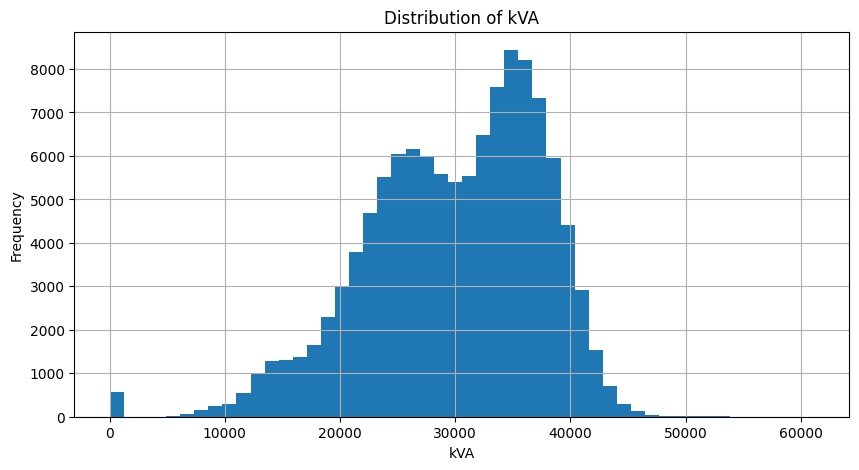

In [ ]:
#Visualize Distribution of kVA
import matplotlib.pyplot as plt

# Histogram of kVA
plt.figure(figsize=(10, 5))
combined_df['kVA'].hist(bins=50)
plt.title('Distribution of kVA')
plt.xlabel('kVA')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()



In [ ]:
!pip install seaborn


  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.2-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ---- ----------------------------------- 30.7/294.9 kB 1.3 MB/s eta 0:00:01
   -------- ------------------------------ 61.4/294.9 kB 812.7 kB/s eta 0:00:01
   -------------- ----------------------- 112.6/294.9 kB 939.4 kB/s eta 0:00:01
   ------------------ ------------------- 143.4/294.9 kB 774.0 kB/s eta 0:00:01
   ------------------------- ------------ 194.6/294.9 kB 841.6 kB/s eta 0:00:01
   ------------------------------ ------- 235.5/294.9 kB 846.9 kB/s eta 0:00:01
   -------------------------------------- 294.9/294.9 kB 909.5 kB/s eta 0:00:00



[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


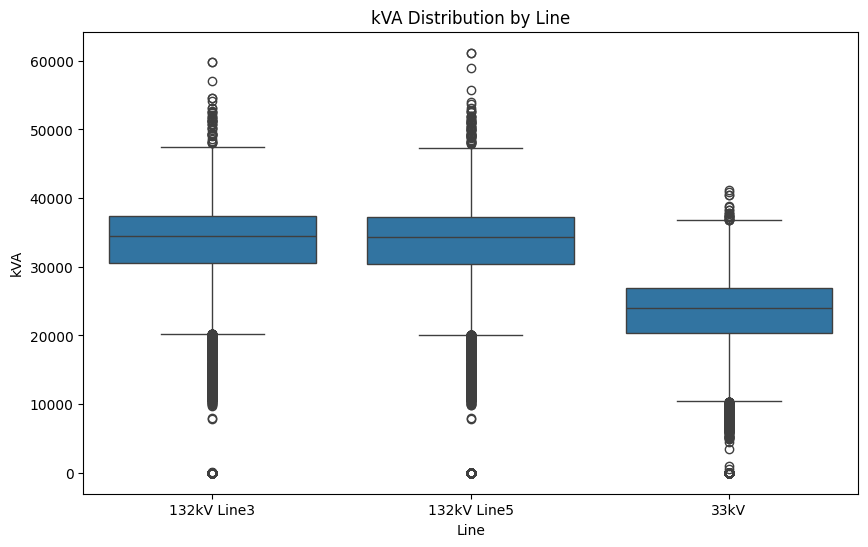

In [ ]:
#Compare kVA Across Lines
import seaborn as sns

# Boxplot to compare distribution by line
plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_df, x='Line', y='kVA')
plt.title('kVA Distribution by Line')
plt.show()

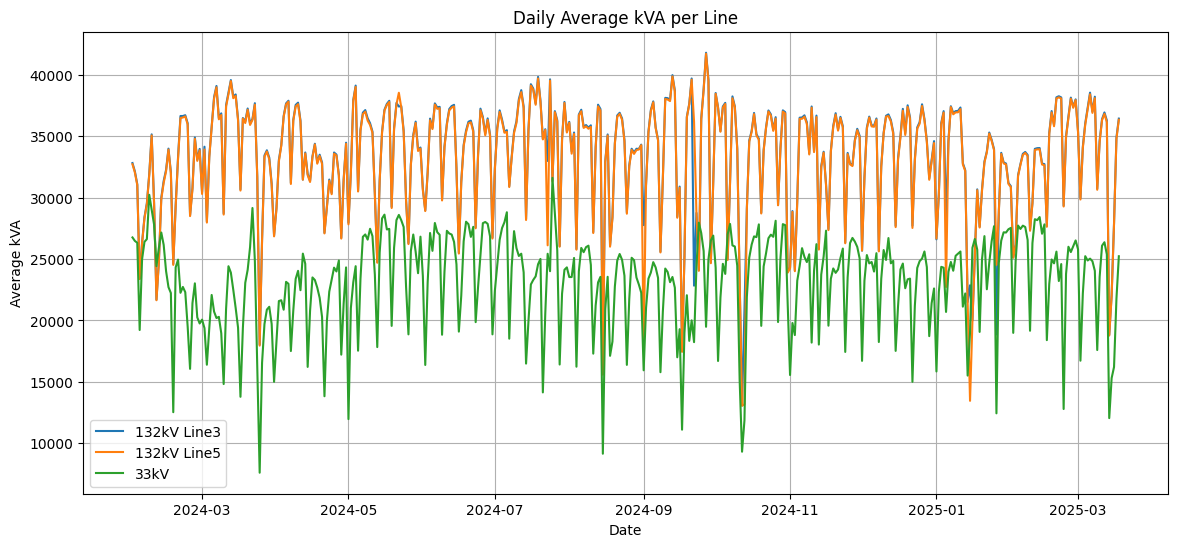

In [ ]:
#Time series trends for each line
# Resample to daily average for clarity
daily_avg = combined_df.groupby('Line').resample('D').mean().reset_index()

plt.figure(figsize=(14, 6))
for line in daily_avg['Line'].unique():
    subset = daily_avg[daily_avg['Line'] == line]
    plt.plot(subset['Datetime'], subset['kVA'], label=line)

plt.title('Daily Average kVA per Line')
plt.xlabel('Date')
plt.ylabel('Average kVA')
plt.legend()
plt.grid(True)
plt.show()


Feature Engineering & Time-Series Preparation

In [57]:
# Rolling statistics (for trend + seasonality capture)
combined_df['kVA_rolling_mean'] = combined_df['kVA'].rolling(window=24).mean()
combined_df['kVA_rolling_std'] = combined_df['kVA'].rolling(window=24).std()


In [58]:
#Lag features (for prediction models)
#These help time-series models learn from past values
combined_df['kVA_lag_1'] = combined_df['kVA'].shift(1)
combined_df['kVA_lag_2'] = combined_df['kVA'].shift(2)
combined_df['kVA_lag_3'] = combined_df['kVA'].shift(3)


In [59]:
#Difference feature (to detect change)
combined_df['kVA_diff'] = combined_df['kVA'].diff()


In [60]:
#check the index type
print(combined_df.index)
print(type(combined_df.index))


DatetimeIndex(['2024-02-01 00:00:00', '2024-02-01 00:00:00',
               '2024-02-01 00:00:00', '2024-02-01 00:15:00',
               '2024-02-01 00:15:00', '2024-02-01 00:15:00',
               '2024-02-01 00:30:00', '2024-02-01 00:30:00',
               '2024-02-01 00:30:00', '2024-02-01 00:45:00',
               ...
               '2025-03-18 23:00:00', '2025-03-18 23:15:00',
               '2025-03-18 23:15:00', '2025-03-18 23:15:00',
               '2025-03-18 23:30:00', '2025-03-18 23:30:00',
               '2025-03-18 23:30:00', '2025-03-18 23:45:00',
               '2025-03-18 23:45:00', '2025-03-18 23:45:00'],
              dtype='datetime64[ns]', name='Datetime', length=116674, freq=None)
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [31]:
#drop the rows with invalid datetime values
# Drop rows with NaT in index
#combined_df = combined_df[combined_df.index.notna()]


In [61]:
combined_df = combined_df.sort_index()

In [62]:
#Re-check that the index is clean

print(combined_df.index)
print(combined_df.index.is_monotonic_increasing)

DatetimeIndex(['2024-02-01 00:00:00', '2024-02-01 00:00:00',
               '2024-02-01 00:00:00', '2024-02-01 00:15:00',
               '2024-02-01 00:15:00', '2024-02-01 00:15:00',
               '2024-02-01 00:30:00', '2024-02-01 00:30:00',
               '2024-02-01 00:30:00', '2024-02-01 00:45:00',
               ...
               '2025-03-18 23:00:00', '2025-03-18 23:15:00',
               '2025-03-18 23:15:00', '2025-03-18 23:15:00',
               '2025-03-18 23:30:00', '2025-03-18 23:30:00',
               '2025-03-18 23:30:00', '2025-03-18 23:45:00',
               '2025-03-18 23:45:00', '2025-03-18 23:45:00'],
              dtype='datetime64[ns]', name='Datetime', length=116674, freq=None)
True


In [63]:
#Extract the time-based features
combined_df['hour'] = combined_df.index.hour
combined_df['day_of_week'] = combined_df.index.dayofweek
combined_df['month'] = combined_df.index.month


In [64]:
#verify feature extraction
print(combined_df[['kVA', 'hour', 'day_of_week', 'month']].head())


                         kVA  hour  day_of_week  month
Datetime                                              
2024-02-01 00:00:00  33812.0     0            3      2
2024-02-01 00:00:00  33711.0     0            3      2
2024-02-01 00:00:00  27237.0     0            3      2
2024-02-01 00:15:00  25668.0     0            3      2
2024-02-01 00:15:00  34861.0     0            3      2


In [65]:
# Check unique values in each time-based column
print("Hour values:", combined_df['hour'].unique())
print("Day of Week values:", combined_df['day_of_week'].unique())
print("Month values:", combined_df['month'].unique())

# Spot check a few timestamps
print(combined_df.iloc[0].name, combined_df.iloc[0][['hour', 'day_of_week', 'month']])
print(combined_df.iloc[1000].name, combined_df.iloc[1000][['hour', 'day_of_week', 'month']])


Hour values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Day of Week values: [3 4 5 6 0 1 2]
Month values: [ 2  3  4  5  6  7  8  9 10 11 12  1]
2024-02-01 00:00:00 hour           0
day_of_week    3
month          2
Name: 2024-02-01 00:00:00, dtype: object
2024-02-04 09:45:00 hour           9
day_of_week    6
month          2
Name: 2024-02-04 09:45:00, dtype: object


In [ ]:
combined_df.dropna(inplace=True)


In [67]:
print(combined_df.isnull().sum())


kVA                  0
Line                 0
hour                 0
day_of_week          0
month                0
kVA_rolling_mean    23
kVA_rolling_std     23
kVA_lag_1            1
kVA_lag_2            2
kVA_lag_3            3
kVA_diff             1
dtype: int64


In [ ]:
pip install holidays


[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [102]:
import pandas as pd
import holidays

# Load your dataset
df = pd.read_excel('cleaned_132kV_Line5.xlsx')

# Convert Datetime column to datetime, forcing invalid dates to NaT
df['Datetime'] = pd.to_datetime(df['Datetime'], errors='coerce')

# Extract only the date (without time) for holiday/weekend checks
# We drop NaT (Not a Time) values here to prevent errors
df['Date'] = df['Datetime'].dt.date

# Create holiday calendar for India, ignoring any NaN years
valid_years = df['Datetime'].dt.year.dropna().unique().astype(int).tolist()
indian_holidays = holidays.India(years=valid_years)

# Add holiday feature
df['Is_Holiday'] = df['Date'].isin(indian_holidays)

# Add weekend feature (Saturday=5, Sunday=6)
df['Is_Weekend'] = df['Datetime'].dt.weekday >= 5

df.head()

,Datetime,kVA,Line,Date,Is_Holiday,Is_Weekend
0,2024-02-01 00:00:00,33711,132kV Line5,2024-02-01,False,False
1,2024-02-01 00:15:00,34573,132kV Line5,2024-02-01,False,False
2,2024-02-01 00:30:00,33068,132kV Line5,2024-02-01,False,False
3,2024-02-01 00:45:00,33908,132kV Line5,2024-02-01,False,False
4,2024-02-01 01:00:00,32714,132kV Line5,2024-02-01,False,False


In [98]:
print(df['Datetime'].isna().sum())


3


In [101]:
full_range = pd.date_range(start=df['Datetime'].min(), end=df['Datetime'].max(), freq='H')  
missing_times = full_range.difference(df['Datetime'])  
print("Missing timestamps:", len(missing_times))


Missing timestamps: 534


C:\Users\Shruti\AppData\Local\Temp\ipykernel_28904\1698677848.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=df['Datetime'].min(), end=df['Datetime'].max(), freq='H')


In [77]:
df['Datetime'] = df['Datetime'].fillna(method='ffill')  # forward fill
df['Datetime'] = df['Datetime'].fillna(method='bfill')  # backward fill


C:\Users\Shruti\AppData\Local\Temp\ipykernel_28904\1532876859.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Datetime'] = df['Datetime'].fillna(method='ffill')  # forward fill
C:\Users\Shruti\AppData\Local\Temp\ipykernel_28904\1532876859.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Datetime'] = df['Datetime'].fillna(method='bfill')  # backward fill


In [99]:
print(df['Datetime'].isna().sum())
print(df[df['Datetime'].isna()])


3
      Datetime    kVA         Line Date
38883      NaT  61171  132kV Line5  NaT
38884      NaT  33217  132kV Line5  NaT
38885      NaT      0  132kV Line5  NaT


In [100]:
import pandas as pd

df = pd.read_excel('cleaned_132kV_Line5.xlsx')
print(df.columns)


Index(['Datetime', 'kVA', 'Line'], dtype='object')


Train-Test Split + Model Training

In [69]:
#Random Forest Regression Model for kVA Prediction

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Select features and target
features = ['kVA_rolling_mean', 'kVA_rolling_std', 'kVA_lag_1', 'kVA_lag_2', 'kVA_lag_3', 'kVA_diff', 'hour', 'day_of_week', 'month']
target = 'kVA'

# Drop NA rows that might still be present
combined_df = combined_df.dropna()

X = combined_df[features]
y = combined_df[target]

# Chronological split (80% train, 20% test)
split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Train Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("R2 Score:", r2)


MAE: 118.62495220950666
RMSE: 689.8367450077957
R2 Score: 0.9911366202524987


In [ ]:
#To calculate how many predictions fall within an acceptable range
# Convert y_test and y_pred to arrays for easier comparison
actual = y_test.values
predicted = y_pred

# Define tolerance range (e.g., ±5%)
tolerance = 0.05

within_range = 0
above_range = 0
below_range = 0

for a, p in zip(actual, predicted):
    lower_bound = a * (1 - tolerance)
    upper_bound = a * (1 + tolerance)

    if lower_bound <= p <= upper_bound:
        within_range += 1
    elif p > upper_bound:
        above_range += 1
    else:
        below_range += 1

total = len(actual)

print(f"Total predictions: {total}")
print(f"Within ±5% range: {within_range} ({within_range/total*100:.2f}%)")
print(f"Above range: {above_range} ({above_range/total*100:.2f}%)")
print(f"Below range: {below_range} ({below_range/total*100:.2f}%)")


Total predictions: 23331
Within ±5% range: 23258 (99.69%)
Above range: 52 (0.22%)
Below range: 21 (0.09%)


In [ ]:
#XGBoost Regressor
!pip install xgboost



[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/b8/84/9d0618b1bc0d9dd421b9a44a472535e353c27703ae42ab8db86b2ea33a25/xgboost-3.0.3-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/149.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/149.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/149.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/149.9 MB ? eta -:--:--
   ---------------------------------------- 0.1/149.9 MB 544.7 kB/s eta 0:04:36
   ---------------------------------------- 0.1/149.9 MB 655.4 kB/s eta 0:03:49
   ---------------------------------------- 0.1/149.9 MB 655.4 kB/s eta 0:03:49
   ---------------------------------------- 0.1/149.9 MB 655.4 kB/s eta 0:03:49
   ---------------------------------------- 0.1/149.9 MB 655.4 kB/s eta 0:03:49
   ---------------------------------------- 0.2/149.9 MB 523.5 kB/s eta 0:04:47
   ---------------------------

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Define model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# Train
xgb_model.fit(X_train, y_train)

# Predict
xgb_preds = xgb_model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, xgb_preds)
rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
r2 = r2_score(y_test, xgb_preds)

print(f"XGBoost MAE: {mae}")
print(f"XGBoost RMSE: {rmse}")
print(f"XGBoost R² Score: {r2}")


XGBoost MAE: 114.82987848999394
XGBoost RMSE: 406.1880565621052
XGBoost R² Score: 0.99692701098447


In [71]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Convert to NumPy arrays
X_train_np = X_train.values
X_test_np = X_test.values

# Reshape for LSTM [samples, timesteps, features]
X_train_lstm = X_train_np.reshape((X_train_np.shape[0], 1, X_train_np.shape[1]))
X_test_lstm = X_test_np.reshape((X_test_np.shape[0], 1, X_test_np.shape[1]))

# Define LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

# Train model
lstm_model.fit(X_train_lstm, y_train.values, epochs=50, batch_size=32, verbose=1)

# Predict
lstm_preds = lstm_model.predict(X_test_lstm)

# Evaluate
mae = mean_absolute_error(y_test.values, lstm_preds)
rmse = np.sqrt(mean_squared_error(y_test.values, lstm_preds))
r2 = r2_score(y_test.values, lstm_preds)

print(f"LSTM MAE: {mae}")
print(f"LSTM RMSE: {rmse}")
print(f"LSTM R² Score: {r2}")


c:\Users\Shruti\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 54998996.0000
Epoch 2/50
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 124183.7578
Epoch 3/50
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 62474.9727
Epoch 4/50
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 34471.0820
Epoch 5/50
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 25437.3027
Epoch 6/50
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 13095.3135
Epoch 7/50
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 9686.8691
Epoch 8/50
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 6237.6255
Epoch 9/50
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 10181.7002
Epoch 10/50
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 9812.7568
Epoch 11/50
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 7782.9219
Epoch 12/50
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 10958.3115
Epoch 13/50
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 3883.8953
Epoch 14/50
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 5s 2m

In [72]:

# Save the LSTM model
lstm_model.save("lstm_regressor_model.h5")
print("Model saved successfully!")


Model saved successfully!


In [73]:
# Save the LSTM model in native Keras format
lstm_model.save("lstm_regressor_model.keras")
print("Model saved in native Keras format successfully!")


Model saved in native Keras format successfully!
